# Red Neuronal para Predicción de Abandono de Clientes Telco

## Descripción del Proyecto
Este notebook implementa una **red neuronal profunda** usando **PyTorch** para predecir el abandono de clientes (churn) en una empresa de telecomunicaciones.

### Características del modelo:
- 4 capas ocultas con arquitectura: 128 → 64 → 32 → 16 neuronas
- Batch Normalization y Dropout para regularización
- Early stopping y reducción de learning rate
- Métricas completas de clasificación

---


In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve, auc)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

# Configurar dispositivo (GPU si está disponible)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo utilizado: {device}")

Dispositivo utilizado: cpu


## 1. Carga y Exploración de Datos

In [2]:
# Cargar el Dataset de Abandono de Clientes de Telco
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

print("="*60)
print("ABANDONO DE CLIENTES TELCO - ENTRENAMIENTO RED NEURONAL")
print("="*60)
print(f"\nForma del Dataset: {df.shape}")
print(f"\nPrimeras filas:")
print(df.head())
print(f"\nDistribución de Abandono:")
print(df['Churn'].value_counts())
print(f"\nInformación del Dataset:")
print(df.info())

ABANDONO DE CLIENTES TELCO - ENTRENAMIENTO RED NEURONAL

Forma del Dataset: (7043, 21)

Primeras filas:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic

## 2. Preprocesamiento de Datos

In [3]:
# Preprocesamiento de Datos
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)
df = df.drop('customerID', axis=1)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

X = df.drop('Churn', axis=1)
y = df['Churn']

# Codificar variables categóricas
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

print(f"Características: {X.shape[1]}")
print(f"Tasa de Abandono: {y.mean():.2%}")

Características: 19
Tasa de Abandono: 26.54%


## 3. División y Escalado de Datos

In [4]:
# Dividir los datos en entrenamiento, validación y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Conjunto de Entrenamiento: {X_train_scaled.shape}")
print(f"Conjunto de Validación: {X_val_scaled.shape}")
print(f"Conjunto de Prueba: {X_test_scaled.shape}")

Conjunto de Entrenamiento: (4507, 19)
Conjunto de Validación: (1127, 19)
Conjunto de Prueba: (1409, 19)


In [5]:
# Convertir a tensores de PyTorch
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train.values).to(device)
X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
y_val_tensor = torch.FloatTensor(y_val.values).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test.values).to(device)

# Crear DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("✓ Datos convertidos a tensores de PyTorch")
print("✓ DataLoaders creados")

✓ Datos convertidos a tensores de PyTorch
✓ DataLoaders creados


## 4. Definición de la Arquitectura de la Red Neuronal

In [6]:
# Definir la arquitectura de la Red Neuronal
class RedNeuronalChurn(nn.Module):
    def __init__(self, input_size):
        super(RedNeuronalChurn, self).__init__()

        # Primera capa oculta
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)

        # Segunda capa oculta
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)

        # Tercera capa oculta
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.2)

        # Cuarta capa oculta
        self.fc4 = nn.Linear(32, 16)
        self.dropout4 = nn.Dropout(0.2)

        # Capa de salida
        self.fc5 = nn.Linear(16, 1)

        # Funciones de activación
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Primera capa
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        # Segunda capa
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)

        # Tercera capa
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)

        # Cuarta capa
        x = self.fc4(x)
        x = self.relu(x)
        x = self.dropout4(x)

        # Capa de salida
        x = self.fc5(x)
        x = self.sigmoid(x)

        return x

# Inicializar el modelo
input_size = X_train_scaled.shape[1]
modelo = RedNeuronalChurn(input_size).to(device)

# Contar parámetros
total_params = sum(p.numel() for p in modelo.parameters())
trainable_params = sum(p.numel() for p in modelo.parameters() if p.requires_grad)

print("="*60)
print("ARQUITECTURA DEL MODELO")
print("="*60)
print(modelo)
print(f"\nParámetros totales: {total_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")

ARQUITECTURA DEL MODELO
RedNeuronalChurn(
  (fc1): Linear(in_features=19, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=32, out_features=16, bias=True)
  (dropout4): Dropout(p=0.2, inplace=False)
  (fc5): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

Parámetros totales: 13,889
Parámetros entrenables: 13,889


## 5. Configuración del Entrenamiento

In [8]:
# Definir función de pérdida y optimizador
criterio = nn.BCELoss()
optimizador = optim.Adam(modelo.parameters(), lr=0.001, weight_decay=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizador, mode='min', factor=0.5, patience=5)

print("✓ Función de pérdida: Binary Cross Entropy")
print("✓ Optimizador: Adam (lr=0.001, weight_decay=0.001)")
print("✓ Scheduler: ReduceLROnPlateau")

✓ Función de pérdida: Binary Cross Entropy
✓ Optimizador: Adam (lr=0.001, weight_decay=0.001)
✓ Scheduler: ReduceLROnPlateau


In [9]:
# Función de entrenamiento
def entrenar_epoca(modelo, loader, criterio, optimizador):
    modelo.train()
    perdida_total = 0
    correctos = 0
    total = 0

    for X_batch, y_batch in loader:
        optimizador.zero_grad()
        salidas = modelo(X_batch).squeeze()
        perdida = criterio(salidas, y_batch)
        perdida.backward()
        optimizador.step()

        perdida_total += perdida.item()
        predicciones = (salidas > 0.5).float()
        correctos += (predicciones == y_batch).sum().item()
        total += y_batch.size(0)

    return perdida_total / len(loader), correctos / total

# Función de validación
def validar_epoca(modelo, loader, criterio):
    modelo.eval()
    perdida_total = 0
    correctos = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in loader:
            salidas = modelo(X_batch).squeeze()
            perdida = criterio(salidas, y_batch)

            perdida_total += perdida.item()
            predicciones = (salidas > 0.5).float()
            correctos += (predicciones == y_batch).sum().item()
            total += y_batch.size(0)

    return perdida_total / len(loader), correctos / total

print("✓ Funciones de entrenamiento y validación definidas")

✓ Funciones de entrenamiento y validación definidas


## 6. Entrenamiento del Modelo

In [10]:
# Entrenamiento
print("="*60)
print("ENTRENANDO LA RED NEURONAL...")
print("="*60)

num_epocas = 100
mejor_perdida_val = float('inf')
paciencia = 15
contador_paciencia = 0

historial = {
    'perdida_entrenamiento': [],
    'precision_entrenamiento': [],
    'perdida_validacion': [],
    'precision_validacion': []
}

for epoca in range(num_epocas):
    perdida_train, precision_train = entrenar_epoca(modelo, train_loader, criterio, optimizador)
    perdida_val, precision_val = validar_epoca(modelo, val_loader, criterio)

    historial['perdida_entrenamiento'].append(perdida_train)
    historial['precision_entrenamiento'].append(precision_train)
    historial['perdida_validacion'].append(perdida_val)
    historial['precision_validacion'].append(precision_val)

    scheduler.step(perdida_val)

    if (epoca + 1) % 10 == 0:
        print(f"Época [{epoca+1}/{num_epocas}] - "
              f"Pérdida Train: {perdida_train:.4f}, Precisión Train: {precision_train:.4f} - "
              f"Pérdida Val: {perdida_val:.4f}, Precisión Val: {precision_val:.4f}")

    # Early stopping
    if perdida_val < mejor_perdida_val:
        mejor_perdida_val = perdida_val
        mejor_modelo = modelo.state_dict().copy()
        contador_paciencia = 0
    else:
        contador_paciencia += 1
        if contador_paciencia >= paciencia:
            print(f"\nEarly stopping en época {epoca+1}")
            break

# Cargar el mejor modelo
modelo.load_state_dict(mejor_modelo)
print(f"\n✓ Entrenamiento completado en {len(historial['perdida_entrenamiento'])} épocas")

ENTRENANDO LA RED NEURONAL...
Época [10/100] - Pérdida Train: 0.4337, Precisión Train: 0.7841 - Pérdida Val: 0.4290, Precisión Val: 0.8092
Época [20/100] - Pérdida Train: 0.4209, Precisión Train: 0.7985 - Pérdida Val: 0.4229, Precisión Val: 0.8172

Early stopping en época 29

✓ Entrenamiento completado en 29 épocas


## 7. Evaluación del Modelo

In [11]:
# Evaluación en conjunto de prueba
modelo.eval()
with torch.no_grad():
    y_pred_proba = modelo(X_test_tensor).squeeze().cpu().numpy()
    y_pred = (y_pred_proba > 0.5).astype(int)

y_test_np = y_test.values

# Calcular métricas
print("="*60)
print("MÉTRICAS COMPLETAS DE CLASIFICACIÓN")
print("="*60)

exactitud = accuracy_score(y_test_np, y_pred)
precision = precision_score(y_test_np, y_pred)
sensibilidad = recall_score(y_test_np, y_pred)
f1 = f1_score(y_test_np, y_pred)
roc_auc = roc_auc_score(y_test_np, y_pred_proba)

print(f"\n{'Métrica':<35} {'Puntuación':<10}")
print("-" * 50)
print(f"{'Exactitud (Accuracy)':<35} {exactitud:.4f} ({exactitud*100:.2f}%)")
print(f"{'Precisión (Precision)':<35} {precision:.4f} ({precision*100:.2f}%)")
print(f"{'Sensibilidad (Recall)':<35} {sensibilidad:.4f} ({sensibilidad*100:.2f}%)")
print(f"{'Puntuación F1 (F1-Score)':<35} {f1:.4f} ({f1*100:.2f}%)")
print(f"{'Puntuación ROC-AUC':<35} {roc_auc:.4f} ({roc_auc*100:.2f}%)")

MÉTRICAS COMPLETAS DE CLASIFICACIÓN

Métrica                             Puntuación
--------------------------------------------------
Exactitud (Accuracy)                0.7906 (79.06%)
Precisión (Precision)               0.6223 (62.23%)
Sensibilidad (Recall)               0.5374 (53.74%)
Puntuación F1 (F1-Score)            0.5768 (57.68%)
Puntuación ROC-AUC                  0.8378 (83.78%)


In [12]:
# Matriz de confusión
cm = confusion_matrix(y_test_np, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\n{'Matriz de Confusión':<35} {'Cantidad':<10}")
print("-" * 50)
print(f"{'Verdaderos Negativos (VN)':<35} {tn}")
print(f"{'Falsos Positivos (FP)':<35} {fp}")
print(f"{'Falsos Negativos (FN)':<35} {fn}")
print(f"{'Verdaderos Positivos (VP)':<35} {tp}")

# Métricas adicionales
especificidad = tn / (tn + fp)
vpn = tn / (tn + fn) if (tn + fn) > 0 else 0
vpp = tp / (tp + fp) if (tp + fp) > 0 else 0
tasa_fp = fp / (fp + tn)
tasa_fn = fn / (fn + tp)

print(f"\n{'Métricas Adicionales':<35} {'Puntuación':<10}")
print("-" * 50)
print(f"{'Especificidad':<35} {especificidad:.4f} ({especificidad*100:.2f}%)")
print(f"{'Valor Predictivo Negativo (VPN)':<35} {vpn:.4f} ({vpn*100:.2f}%)")
print(f"{'Valor Predictivo Positivo (VPP)':<35} {vpp:.4f} ({vpp*100:.2f}%)")
print(f"{'Tasa de Falsos Positivos':<35} {tasa_fp:.4f} ({tasa_fp*100:.2f}%)")
print(f"{'Tasa de Falsos Negativos':<35} {tasa_fn:.4f} ({tasa_fn*100:.2f}%)")


Matriz de Confusión                 Cantidad  
--------------------------------------------------
Verdaderos Negativos (VN)           913
Falsos Positivos (FP)               122
Falsos Negativos (FN)               173
Verdaderos Positivos (VP)           201

Métricas Adicionales                Puntuación
--------------------------------------------------
Especificidad                       0.8821 (88.21%)
Valor Predictivo Negativo (VPN)     0.8407 (84.07%)
Valor Predictivo Positivo (VPP)     0.6223 (62.23%)
Tasa de Falsos Positivos            0.1179 (11.79%)
Tasa de Falsos Negativos            0.4626 (46.26%)


In [13]:
# Reporte de clasificación
print("="*60)
print("REPORTE DETALLADO DE CLASIFICACIÓN")
print("="*60)
print(classification_report(y_test_np, y_pred, target_names=['Sin Abandono', 'Con Abandono'], digits=4))

REPORTE DETALLADO DE CLASIFICACIÓN
              precision    recall  f1-score   support

Sin Abandono     0.8407    0.8821    0.8609      1035
Con Abandono     0.6223    0.5374    0.5768       374

    accuracy                         0.7906      1409
   macro avg     0.7315    0.7098    0.7188      1409
weighted avg     0.7827    0.7906    0.7855      1409



## 8. Visualizaciones

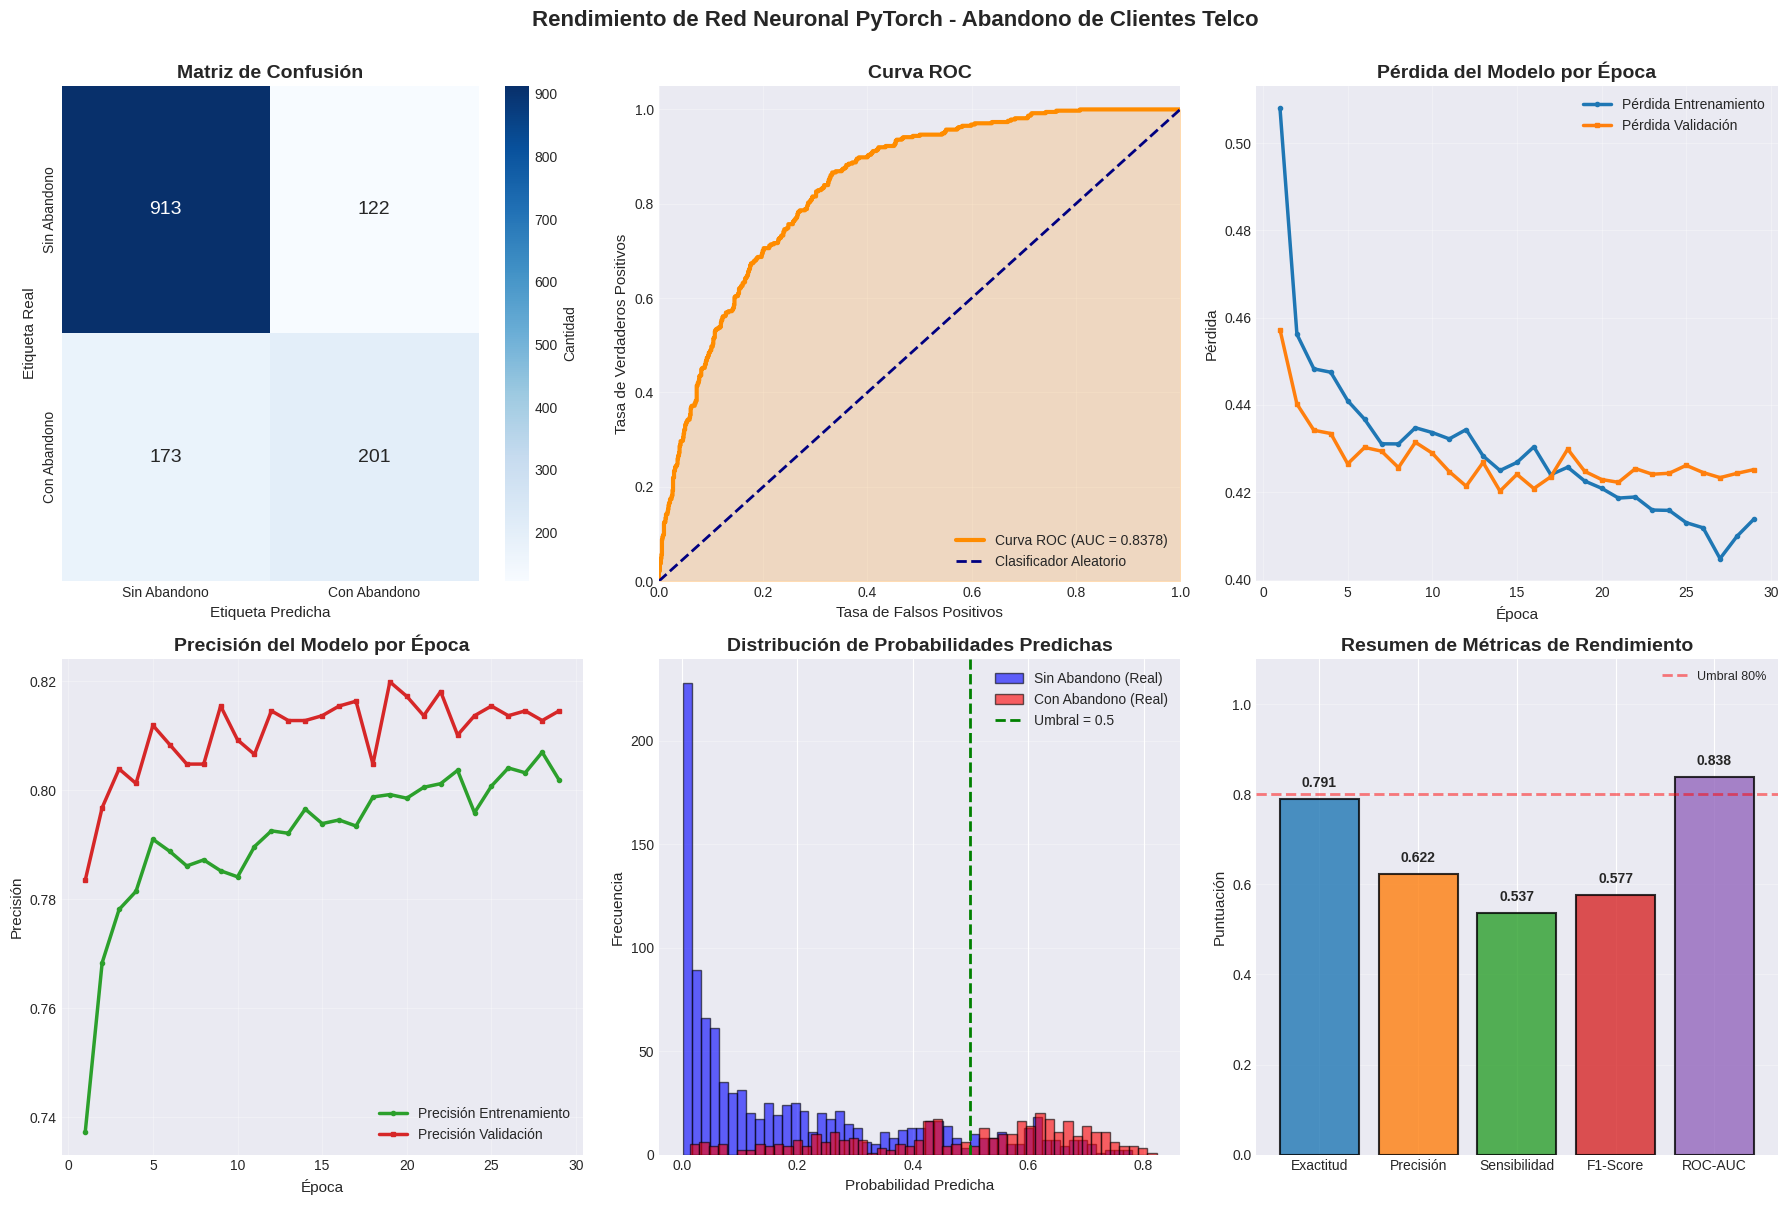


✓ ¡Visualizaciones generadas exitosamente!


In [14]:
# Configurar estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Crear figura con subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Rendimiento de Red Neuronal PyTorch - Abandono de Clientes Telco',
             fontsize=16, fontweight='bold', y=1.00)

# 1. Matriz de Confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Sin Abandono', 'Con Abandono'],
            yticklabels=['Sin Abandono', 'Con Abandono'],
            cbar_kws={'label': 'Cantidad'}, annot_kws={'size': 14})
axes[0, 0].set_title('Matriz de Confusión', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Etiqueta Real', fontsize=11)
axes[0, 0].set_xlabel('Etiqueta Predicha', fontsize=11)

# 2. Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_np, y_pred_proba)
roc_auc_curve = auc(fpr, tpr)
axes[0, 1].plot(fpr, tpr, color='darkorange', lw=3,
                label=f'Curva ROC (AUC = {roc_auc_curve:.4f})')
axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                label='Clasificador Aleatorio')
axes[0, 1].fill_between(fpr, tpr, alpha=0.2, color='darkorange')
axes[0, 1].set_xlim([0.0, 1.0])
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlabel('Tasa de Falsos Positivos', fontsize=11)
axes[0, 1].set_ylabel('Tasa de Verdaderos Positivos', fontsize=11)
axes[0, 1].set_title('Curva ROC', fontsize=14, fontweight='bold')
axes[0, 1].legend(loc="lower right", fontsize=10)
axes[0, 1].grid(alpha=0.3)

# 3. Historial de Entrenamiento - Pérdida
epocas = range(1, len(historial['perdida_entrenamiento']) + 1)
axes[0, 2].plot(epocas, historial['perdida_entrenamiento'],
                label='Pérdida Entrenamiento', linewidth=2.5, color='#1f77b4', marker='o', markersize=3)
axes[0, 2].plot(epocas, historial['perdida_validacion'],
                label='Pérdida Validación', linewidth=2.5, color='#ff7f0e', marker='s', markersize=3)
axes[0, 2].set_title('Pérdida del Modelo por Época', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Época', fontsize=11)
axes[0, 2].set_ylabel('Pérdida', fontsize=11)
axes[0, 2].legend(fontsize=10)
axes[0, 2].grid(alpha=0.3)

# 4. Historial de Entrenamiento - Precisión
axes[1, 0].plot(epocas, historial['precision_entrenamiento'],
                label='Precisión Entrenamiento', linewidth=2.5, color='#2ca02c', marker='o', markersize=3)
axes[1, 0].plot(epocas, historial['precision_validacion'],
                label='Precisión Validación', linewidth=2.5, color='#d62728', marker='s', markersize=3)
axes[1, 0].set_title('Precisión del Modelo por Época', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Época', fontsize=11)
axes[1, 0].set_ylabel('Precisión', fontsize=11)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(alpha=0.3)

# 5. Distribución de Probabilidades Predichas
axes[1, 1].hist(y_pred_proba[y_test_np == 0], bins=50, alpha=0.6,
                label='Sin Abandono (Real)', color='blue', edgecolor='black')
axes[1, 1].hist(y_pred_proba[y_test_np == 1], bins=50, alpha=0.6,
                label='Con Abandono (Real)', color='red', edgecolor='black')
axes[1, 1].axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='Umbral = 0.5')
axes[1, 1].set_title('Distribución de Probabilidades Predichas', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Probabilidad Predicha', fontsize=11)
axes[1, 1].set_ylabel('Frecuencia', fontsize=11)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(alpha=0.3, axis='y')

# 6. Resumen de Métricas
metricas_nombres = ['Exactitud', 'Precisión', 'Sensibilidad', 'F1-Score', 'ROC-AUC']
metricas_valores = [exactitud, precision, sensibilidad, f1, roc_auc]
colores = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
barras = axes[1, 2].bar(metricas_nombres, metricas_valores, color=colores,
                        alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1, 2].set_title('Resumen de Métricas de Rendimiento', fontsize=14, fontweight='bold')
axes[1, 2].set_ylabel('Puntuación', fontsize=11)
axes[1, 2].set_ylim([0, 1.1])
axes[1, 2].grid(axis='y', alpha=0.3)
axes[1, 2].axhline(y=0.8, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Umbral 80%')
axes[1, 2].legend(fontsize=9)
for barra in barras:
    altura = barra.get_height()
    axes[1, 2].text(barra.get_x() + barra.get_width()/2., altura + 0.02,
                    f'{altura:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('red_neuronal_pytorch_metricas.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ ¡Visualizaciones generadas exitosamente!")

## 9. Resumen Final

In [15]:
# Resumen del modelo
print("="*60)
print("RESUMEN DEL MODELO")
print("="*60)
print(f"Parámetros Totales: {total_params:,}")
print(f"Muestras de Entrenamiento: {len(X_train_scaled)}")
print(f"Muestras de Validación: {len(X_val_scaled)}")
print(f"Muestras de Prueba: {len(X_test_scaled)}")
print(f"Número de Características: {X_train_scaled.shape[1]}")
print(f"Épocas Entrenadas: {len(historial['perdida_entrenamiento'])}")
print("\n✓ ¡Entrenamiento de Red Neuronal Completado!")
print("✓ ¡Todas las métricas de clasificación calculadas!")

RESUMEN DEL MODELO
Parámetros Totales: 13,889
Muestras de Entrenamiento: 4507
Muestras de Validación: 1127
Muestras de Prueba: 1409
Número de Características: 19
Épocas Entrenadas: 29

✓ ¡Entrenamiento de Red Neuronal Completado!
✓ ¡Todas las métricas de clasificación calculadas!


## 10. Guardar el Modelo (Opcional)

In [16]:
# Guardar el modelo entrenado
torch.save({
    'model_state_dict': modelo.state_dict(),
    'optimizer_state_dict': optimizador.state_dict(),
    'scaler': scaler,
    'historial': historial,
    'metricas': {
        'exactitud': exactitud,
        'precision': precision,
        'sensibilidad': sensibilidad,
        'f1': f1,
        'roc_auc': roc_auc
    }
}, 'modelo_churn_pytorch.pth')

print("✓ Modelo guardado como 'modelo_churn_pytorch.pth'")

# Para cargar el modelo más tarde:
# checkpoint = torch.load('modelo_churn_pytorch.pth')
# modelo.load_state_dict(checkpoint['model_state_dict'])
# optimizador.load_state_dict(checkpoint['optimizer_state_dict'])
# scaler = checkpoint['scaler']
# historial = checkpoint['historial']
# metricas = checkpoint['metricas']

✓ Modelo guardado como 'modelo_churn_pytorch.pth'
